# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [48]:
#useful tool for debugging
!pip install icecream

In [49]:
#all other imports 
import icecream as ic

In [3]:
#useful variables
addtional_customer_cols = ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
azdias_num_rows = 891221
azdias_num_cols = 366
customers_num_rows = 191652
customers_num_cols = 369

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
%timeit
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#observe warning above - 5 columns have mixed types.  Then need to be identified and addressed

In [5]:
#check the correct rows and cols are loaded
print("azdias: ",azdias.shape)
print("customers: ",customers.shape)

#make a copy of the df
azdias_org = azdias
customers_org = customers

azdias:  (891221, 366)
customers:  (191652, 369)


In [ ]:
azdias.head(5)

In [ ]:
customers.head(5)

In [7]:
#load the values and attributes
attributes_value_ranges = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header =1)
attributes_descriptions = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header = 1)


In [29]:
dias_values["Attribute"] = dias_values["Attribute"].ffill()
dias_values.head(10)

Attribute                                   Description  \
NaN              AGER_TYP                            best-ager typology   
NaN              AGER_TYP                                           NaN   
NaN              AGER_TYP                                           NaN   
NaN              AGER_TYP                                           NaN   
NaN              AGER_TYP                                           NaN   
NaN  ALTERSKATEGORIE_GROB  age classification through prename analysis    
NaN  ALTERSKATEGORIE_GROB                                           NaN   
NaN  ALTERSKATEGORIE_GROB                                           NaN   
NaN  ALTERSKATEGORIE_GROB                                           NaN   
NaN  ALTERSKATEGORIE_GROB                                           NaN   

     Value                     Meaning  
NaN     -1                     unknown  
NaN      0  no classification possible  
NaN      1             passive elderly  
NaN      2            cultural elderly  
NaN      3   experience-driven elderly  
NaN  -1, 0                     unknown  
NaN      1                  < 30 years  
NaN      2               30 - 45 years  
NaN      3               46 - 60 years  
NaN      4                  > 60 years

In [103]:
#get the attributes that have unknown as a possible value
attributes_with_unknowns = attributes_value_ranges.loc[dias_values['Meaning'] == 'unknown']


#attributes_with_unknowns.Value
#attributes_with_unknowns.Value.describe()
#titanic[titanic["Pclass"].isin([2, 3])]
#df = pd.DataFrame([-1,0,1,2,3])
#df.columns = ['val']
#df.iloc[0]['val']
#df
#df[df["val"].isin([2, 3])]
#x=df[df["val"].isin([2, 3])]
#print(x)

#attributes_with_unknowns.iloc[1][2]
#attributes_with_unknowns

#if df.iloc[0]['val'].isin(attributes_with_unknowns.iloc[1][2]):
#mList = [int(e) if e.isdigit() else e for e in mStr.split(',')]
#x = df.iloc[0].isin([int(e) if e.isdigit() else e for e in attributes_with_unknowns.iloc[1][2].split(',')])
#print(x)
#attributes_with_unknowns = attributes_value_ranges.loc[dias_values['Meaning'] == 'unknown' | dias_values['Meaning'] == 'no transactions known' | dias_values['Meaning'] == 'no transactions known']
attributes_with_unknowns = attributes_value_ranges.loc[dias_values['Meaning'] == 'unknown']
attributes_with_unknowns = attributes_with_unknowns.append(attributes_value_ranges.loc[dias_values['Meaning'] == 'no transactions known'])
attributes_with_unknowns = attributes_with_unknowns.append(attributes_value_ranges.loc[dias_values['Meaning'] == 'no transaction known'])
attributes_with_unknowns.shape

(288, 4)

In [116]:
#df = df.drop(df[df.score < 50].index)
#df = attributes_with_unknowns
#df = df.drop(df[df.Attribute == 'BIP_FLAG'])
#df_filtered = df[df['Age'] >= 25] 
attributes_with_unknowns = attributes_with_unknowns[attributes_with_unknowns['Attribute'] != 'BIP_FLAG'] 
#attributes_with_unknowns = attributes_with_unknowns.drop(attributes_with_unknowns['Attribute'] == 'BIP_FLAG')
#df_filtered.shape
attributes_with_unknowns.shape

(287, 4)

In [91]:
#df[df['model'].str.contains('ac')]
#x = attributes_value_ranges.loc[dias_values['Meaning'].str.contains('known')]
#x =attributes_value_ranges.loc[dias_values['Meaning'] == 'unknown']
x = attributes_value_ranges.Meaning.unique()

#for i in attributes_value_ranges.Meaning.unique():
    #print(i)
#strings_with_substring = [string for string in x if 'known' in string]

unknown_terms = []
for i in attributes_value_ranges.Meaning.unique():
    if ('KNOWN' in str(i).upper()):
        unknown_terms.append(i)

print(unknown_terms)    

['unknown', 'unknown / no main age detectable', 'no transactions known', 'no transaction known', 'residental building buildings without actually known household', 'mixed building without actually known household or comapny ', 'company building w/o known company ', 'mixed building without actually known household ', 'mixed building without actually known company ']


In [64]:
def value_range_for_attribute(df, sKey_Name):
    '''
    '''
    value_list = []
    cell_value = str(df.loc[df["Attribute"] == sKey_Name, "Value"].values[0]).split(',')
    for i in cell_value:
        value_list.append(int(i))
    
    return value_list

print(value_range_for_attribute(attributes_with_unknowns, 'WOHNLAGE'))

[-1]


In [102]:
#azdias_sub.BIP_FLAG.unique()
list(azdias_sub.columns)

['LNR',
 'AGER_TYP',
 'AKT_DAT_KL',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE

In [117]:
pd.set_option('display.max_columns', None)
azdias_sub = azdias.head(15)
attribute_list = attributes_with_unknowns['Attribute'].tolist()
#azdias_sub

def replace_unknown_values_with_nan(df, list_of_attribs):
    '''
    '''
    for attribute in list_of_attribs:
        print("replace_unknown_values_with_nan:", attribute)
        #df['CustomRating'] = df.apply(lambda x: custom_rating(x['Genre'],x['Rating']),axis=1)
        #nan_counts['percent_nan_missing'] = nan_counts[0].apply(lambda x: x*100/len(df))
        #df['col1'] = df.apply(lambda x: complex_function(x['col1']), axis=1)
        #df[attribute] = df[attribute].apply(lambda x:update_cell_to_nan_for_unknown(attribute, x))
        #df['col1'] = df.apply(lambda x: complex_function(x['col1']), axis=1)
        #df[attrib] = df[attrib].apply(replace_unkown_with_nan, args=(unkown))
        #df[attribute] = df[attribute].apply(update_cell_to_nan_for_unknown, args=(attribute))
        df[attribute] = df.apply(lambda x:update_cell_to_nan_for_unknown(attribute, x[attribute]),axis=1)

def update_cell_to_nan_for_unknown(colname, curr_value):
    print("update_cell_to_nan_for_unknown: ", colname)
    print("update_cell_to_nan_for_unknown: ", curr_value)
    #if curr_value.isin(value_range_for_attribute(attributes_with_unknowns,colname)):
    if curr_value in (value_range_for_attribute(attributes_with_unknowns,colname)):
        return np.nan
    else:
        return curr_value

#this is working
#print(update_cell_to_nan_for_unknown("AGER_TYP",-1))

#azdias["AGER_TYP"] = azdias["AGER_TYP"].apply(replace_unkown_with_nan, args=(ager_typ_unkwon))
#azdias_sub["AGER_TYP"] = azdias["AGER_TYP"].apply(update_cell_to_nan_for_unknown, args=(value_range_for_attribute("AGER_TYPE")))
replace_unknown_values_with_nan(azdias_sub, attribute_list)
#azdias_sub

replace_unknown_values_with_nan: AGER_TYP
update_cell_to_nan_for_unknown:  AGER_TYP
update_cell_to_nan_for_unknown:  -1
update_cell_to_nan_for_unknown:  AGER_TYP
update_cell_to_nan_for_unknown:  -1
update_cell_to_nan_for_unknown:  AGER_TYP
update_cell_to_nan_for_unknown:  -1
update_cell_to_nan_for_unknown:  AGER_TYP
update_cell_to_nan_for_unknown:  2
update_cell_to_nan_for_unknown:  AGER_TYP
update_cell_to_nan_for_unknown:  -1
update_cell_to_nan_for_unknown:  AGER_TYP
update_cell_to_nan_for_unknown:  3
update_cell_to_nan_for_unknown:  AGER_TYP
update_cell_to_nan_for_unknown:  -1
update_cell_to_nan_for_unknown:  AGER_TYP
update_cell_to_nan_for_unknown:  -1
update_cell_to_nan_for_unknown:  AGER_TYP
update_cell_to_nan_for_unknown:  -1
update_cell_to_nan_for_unknown:  AGER_TYP
update_cell_to_nan_for_unknown:  -1
update_cell_to_nan_for_unknown:  AGER_TYP
update_cell_to_nan_for_unknown:  0
update_cell_to_nan_for_unknown:  AGER_TYP
update_cell_to_nan_for_unknown:  -1
update_cell_to_nan_for_un

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


replace_unknown_values_with_nan: BALLRAUM
update_cell_to_nan_for_unknown:  BALLRAUM
update_cell_to_nan_for_unknown:  nan
update_cell_to_nan_for_unknown:  BALLRAUM
update_cell_to_nan_for_unknown:  6.0
update_cell_to_nan_for_unknown:  BALLRAUM
update_cell_to_nan_for_unknown:  2.0
update_cell_to_nan_for_unknown:  BALLRAUM
update_cell_to_nan_for_unknown:  4.0
update_cell_to_nan_for_unknown:  BALLRAUM
update_cell_to_nan_for_unknown:  2.0
update_cell_to_nan_for_unknown:  BALLRAUM
update_cell_to_nan_for_unknown:  6.0
update_cell_to_nan_for_unknown:  BALLRAUM
update_cell_to_nan_for_unknown:  6.0
update_cell_to_nan_for_unknown:  BALLRAUM
update_cell_to_nan_for_unknown:  2.0
update_cell_to_nan_for_unknown:  BALLRAUM
update_cell_to_nan_for_unknown:  3.0
update_cell_to_nan_for_unknown:  BALLRAUM
update_cell_to_nan_for_unknown:  6.0
update_cell_to_nan_for_unknown:  BALLRAUM
update_cell_to_nan_for_unknown:  6.0
update_cell_to_nan_for_unknown:  BALLRAUM
update_cell_to_nan_for_unknown:  nan
update_cel

KeyError: ('CAMEO_DEUINTL_2015', 'occurred at index 0')

In [27]:
dias_attribs.head(10)

Information level              Attribute  \
NaN               NaN               AGER_TYP   
NaN            Person   ALTERSKATEGORIE_GROB   
NaN               NaN              ANREDE_KZ   
NaN               NaN          CJT_GESAMTTYP   
NaN               NaN      FINANZ_MINIMALIST   
NaN               NaN          FINANZ_SPARER   
NaN               NaN       FINANZ_VORSORGER   
NaN               NaN         FINANZ_ANLEGER   
NaN               NaN  FINANZ_UNAUFFAELLIGER   
NaN               NaN       FINANZ_HAUSBAUER   

                                           Description  \
NaN                                 best-ager typology   
NaN                      age through prename analysis    
NaN                                             gender   
NaN  Customer-Journey-Typology relating to the pref...   
NaN         financial typology: low financial interest   
NaN                    financial typology: money saver   
NaN                    financial typology: be prepared   
NaN                       financial typology: investor   
NaN                   financial typology: unremarkable   
NaN    financial typology: main focus is the own house   

                                      Additional notes  
NaN  in cooperation with Kantar TNS; the informatio...  
NaN  modelled on millions of first name-age-referen...  
NaN                                                NaN  
NaN  relating to the preferred information, marketi...  
NaN  Gfk-Typology based on a representative househo...  
NaN                                                NaN  
NaN                                                NaN  
NaN                                                NaN  
NaN                                                NaN  
NaN                                                NaN

In [13]:
#find the cols with mixed data types
def findColumnsWithMixedDataTypes(df):
    '''
    '''
    columnsWithMixedDataTypes = []
    for col in df.columns:
        weird = (df[[col]].applymap(type) != df[[col]].iloc[0].apply(type)).any(axis=1)
        if len(df[weird]) > 0:
            #print(col)
            columnsWithMixedDataTypes.append(col)
    
    return columnsWithMixedDataTypes

In [6]:
#Error message on loading: DtypeWarning: Columns (18,19) have mixed types
#=> these are the only two we need to worry about
#first check do they appear in the lists above
print(azdias.columns[18:20])
print(customers.columns[18:20])

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [13]:
mixed_dtype_colnames = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
#note: CAMEO_DEUG_2015 is xxxx on the Attributes s/s

In [ ]:
#look at values in these warning cols
print(pd.value_counts(azdias.CAMEO_DEUG_2015))
print(pd.value_counts(azdias.CAMEO_INTL_2015))

print(pd.value_counts(customers.CAMEO_DEUG_2015))
print(pd.value_counts(customers.CAMEO_INTL_2015))

In [23]:
#method to update these two columns
#NB CAMEO_INTL_2015 is CAMEO_DEINTL_2015 in DIAS Attribute Values 2017 s/s 
#CAMEO_INTL_2015: object type can be set to -1
#CAMEO_DEUG_2015: object type can be set to -1
#also will cast ALL values to ints

def updateMixedDataTypeColumns(df, list_of_cols):
    '''
    '''  
    for col in list_of_cols:
        #first replace the object types with -1
        #df[col].replace({"X": -1, "XX": -1}, inplace=True)
        #first replace the object types with np.nan
        df[col].replace({"X": np.nan, "XX": np.nan}, inplace=True)
        #set Nan to -1
        df[col] = df[col].fillna(-1)
        #cast everything to int
        df[col] = df[col].astype(int)   

In [14]:
updateMixedDataTypeColumns(azdias, mixed_dtype_colnames)
updateMixedDataTypeColumns(customers, mixed_dtype_colnames)

In [15]:
def calc_percent_nan_missing(df):
    '''
    '''
    
    #get a count of the nans
    nan_counts = pd.DataFrame(df.isna().sum())
    #calculate percent_nan_missing
    nan_counts['percent_nan_missing'] = nan_counts[0].apply(lambda x: x*100/len(df))
    #reset the indexes
    nan_counts.reset_index(level=0, inplace=True)
    #set column names
    nan_counts.columns = ['feature', 'count', 'percent_nan_missing']
    #drop sum column
    nan_counts=nan_counts.drop(columns=['count'])
    
    return nan_counts

In [16]:
azdias_nan_cols = calc_percent_nan_missing(azdias)
customers_nan_cols = calc_percent_nan_missing(customers)

In [18]:
def graph_compare_nan_percentages(df1, df1_name, df2, df2_name):
    """
    """
    fig = plt.figure(figsize=(10,80))

    fig.suptitle("NaN %s")

    ax = fig.add_subplot(121)
    ax.set_title(df1_name)
    sns.barplot(y="feature", x="percent_nan_missing", data=df1[df1.percent_nan_missing>=0], ax= ax)

    ax = fig.add_subplot(122)
    ax.set_title(df2_name)
    sns.barplot(y="feature", x="percent_nan_missing", data=df2[df2.percent_nan_missing>=0], ax= ax)

    #fig.tight_layout(rect=[0, 0.03, 1, 0.975])
    fig.tight_layout()
    plt.show()

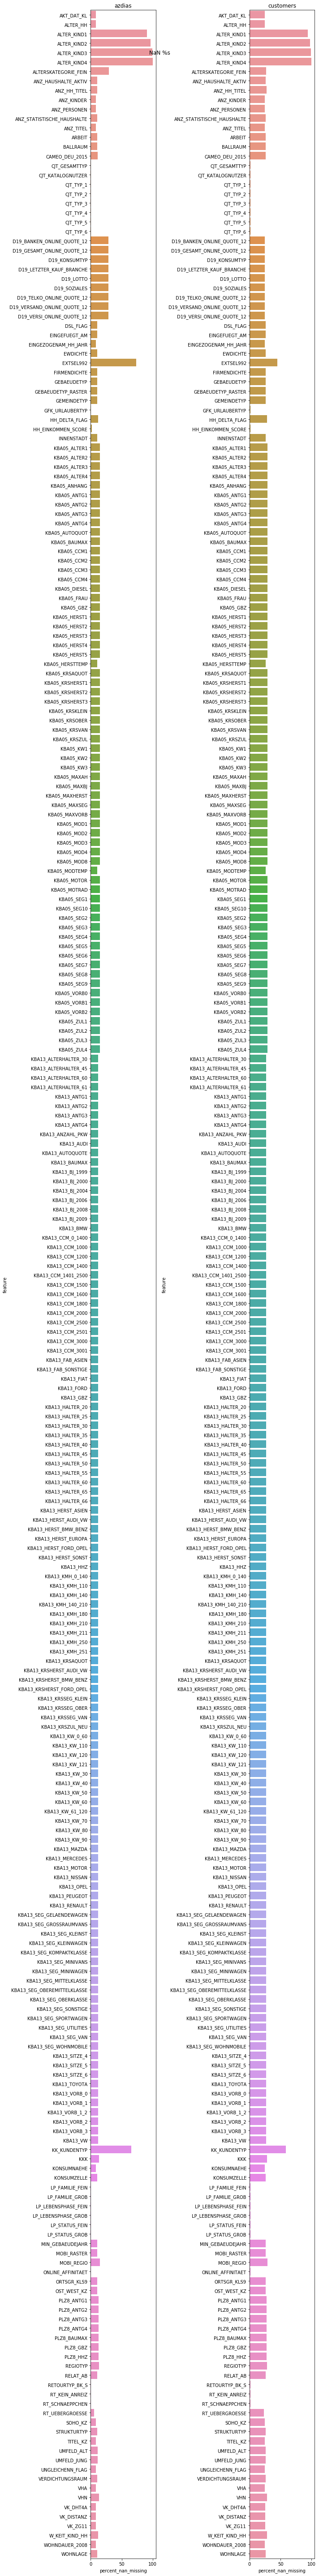

In [19]:
graph_compare_nan_percentages(azdias_nan_cols, 'azdias', customers_nan_cols, 'customers')

In [22]:
def graph_distribution_of_num_attributes(df):
    '''
    '''
    num_attributes = df.select_dtypes(exclude='object')

    fig = plt.figure(figsize=(12,18))
    for i in range(len(num_attributes.columns)):
        fig.add_subplot(9,4,i+1)
        sns.distplot(num_attributes.iloc[:,i].dropna())
        plt.xlabel(num_attributes.columns[i])

    plt.tight_layout()
    plt.show()

ValueError: num must be 1 <= num <= 36, not 37

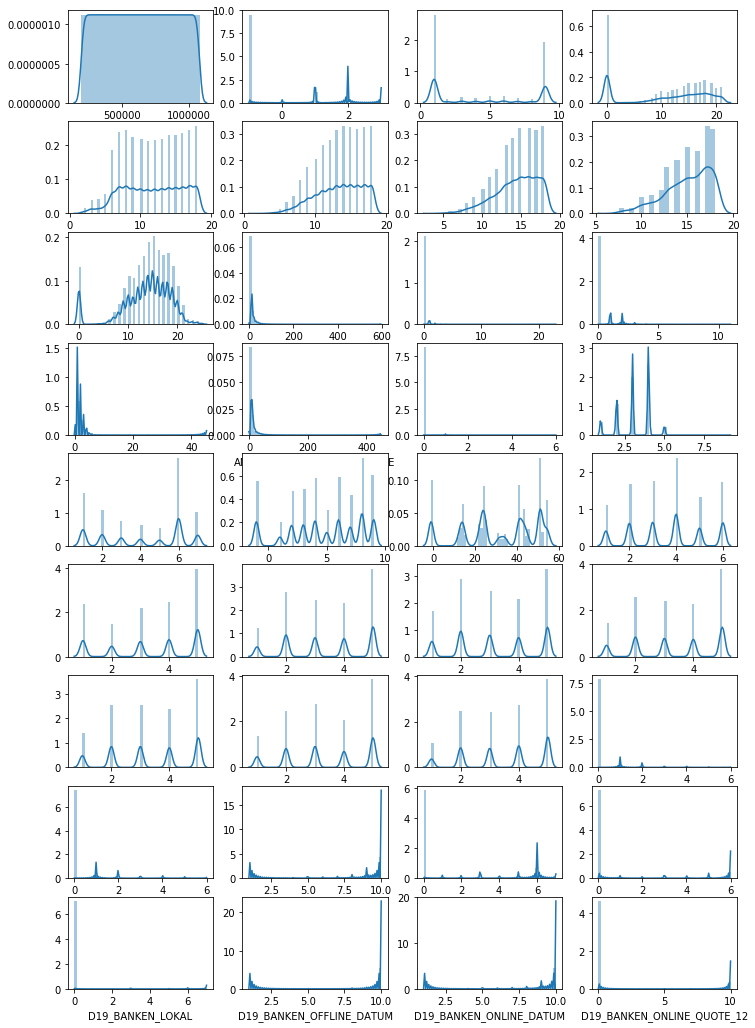

In [21]:
graph_distribution_of_num_attributes(azdias)

In [ ]:
def column_list_of_nans_below_threshold(df,threshold):
    l = []
    l = list(df.drop(df.loc[:,list((100*(df.isnull().sum()/len(df.index))>=threshold))].columns, 1).columns.values)
    print("# Columns having more than %s percent missing values:"%threshold,(df.shape[1] - len(l)))
    print("Columns:\n",list(set(list((df.columns.values))) - set(l)))
    return l

In [ ]:
#look at the numeric attributes #1
num_attributes = customers.select_dtypes(exclude='object')
num_attributes.describe()

In [ ]:
#look at the numeric attributes #2
num_attributes.isna().sum().sort_values(ascending=False).head()

In [ ]:
#look at non-numeric attributes #1
non_num_attributes = customers.select_dtypes(include='object')
non_num_attributes.describe()

In [ ]:
#look at non-numeric attributes #2
non_num_attributes.head
#non_num_attributes.describe()

In [18]:
non_num_attributes.isna().sum().sort_values(ascending=False).head()

CAMEO_INTL_2015    50428
CAMEO_DEUG_2015    50428
CAMEO_DEU_2015     50428
OST_WEST_KZ        49927
EINGEFUEGT_AM      49927
dtype: int64

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')